In [ ]:
%matplotlib widget
# %matplotlib qt
import matplotlib.pyplot as plt
import numpy as np
import bmcs_utils.api as bu
from bmcs_cross_section.api import MKappa, TShape, CustomShape, EC2, BarLayer, ReinfLayer
from bmcs_beam.api import SLSParamStudy, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, BeamSLSCurve, LoadDeflectionParamsStudy
from mpl_toolkits import mplot3d

# Flexural response

In [ ]:
# Concrete C3-HF2-165-4
E_cm_C3 = 43596
f_cm_C3 = 103
fctm_sp = 5.6
fctm_fl = 12.51

# solidian REBAR Ø6 and Ø8
A_phi_6 = 28.2
A_phi_8 = 50.2

# Params study
# Concrete class (according to fib model code)
# C40: f_cm = 48, E_cm = 36300
# C70: f_cm = 78, E_cm = 42600
# C100: f_cm = 108, E_cm = 47500

# z: 20, 50, 80

# B: 200, 500, 800
# H: 100, 300, 500, 700

# concrete: C40
def get_dp(f_cm = 48, E_cm = 36300, n_kappa=100,
           setup='dist', L=2000, L_F=None,
           high_kappa = 0.0001, concrete_law='EC2',
           B=200, H=300, A = None,
           reinf = 'carbon',
           E_nm=None, f_t=None, z=20,
           carbon_type='rebars',
           grid_layers_n=1, grid_layers_spacing=10, grid_layers_area=[]):
    # carbon_type: 'rebars' -> solidian REBAR Ø8-CCE
    # carbon_type: 'grid' -> solidian GRID Q95-CCE-38-E5
    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa, n_kappa=n_kappa)
    
    mc.cs_design.matrix=concrete_law
    
    f_ck = EC2.get_f_ck_from_f_cm(f_cm)
    fctm_fl = EC2.get_f_ctm_fl(f_ck, H)
    if concrete_law == 'EC2 with plateau' or concrete_law == 'EC2':
        mc.cs_design.matrix_.trait_set(f_cm = f_cm)
    elif concrete_law == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
            eps_cy=EC2.get_eps_c3(f_ck),
            eps_cu=EC2.get_eps_cu3(f_ck),
        )
    
    mc.cs_design.matrix_.trait_set(E_cc=E_cm, 
                                   E_ct=E_cm, 
                                   eps_cr = fctm_fl/E_cm, 
                                   eps_tu = fctm_fl/E_cm,)

    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H

    if carbon_type == 'rebars':
        E_nm=158000 if E_nm is None else E_nm
        f_t=2500 if f_t is None else f_t
        if A is None:
            A = 4 * A_phi_8
        if z is None:
            z = 4 + 10
    elif carbon_type == 'grid':
        E_nm=230000 if E_nm is None else E_nm
        f_t=3300 if f_t is None else f_t
        
        spacing = 38
        rov_num = int(B/spacing) + 1
        rov_cs_area = 3.62

        if A is None:
            A = rov_num * rov_cs_area
        if z is None:
            z = 10
       
    d = H - z
    
    if reinf == 'carbon':
        if grid_layers_n == 1:
            bl1 = ReinfLayer(name=carbon_type, z=z, A=A, matmod='carbon')
            bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
            mc.cross_section_layout.add_layer(bl1)
        else:
            for i in range(grid_layers_n):
                if grid_layers_area:
                    bl1 = ReinfLayer(name=carbon_type, z=z + i*grid_layers_spacing, A=grid_layers_area[i], matmod='carbon')
                else:
                    bl1 = ReinfLayer(name=carbon_type, z=z + i*grid_layers_spacing, A=A, matmod='carbon')
                bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
                mc.cross_section_layout.add_layer(bl1)
            A = grid_layers_n * A
    else:
        bl1 = ReinfLayer(name='rebars', z=z, A=A, matmod='steel')
        mc.cross_section_layout.add_layer(bl1)

    rho = A/(B*d)
    print('A=', A)
    print(r'rho =', round(rho * 100, 2), r'%')
    # mechanical reinforcement ratio
#     w_m = A * f_t / (B * H * f_cm)
#     print('w_m:', w_m)

    dp = DeflectionProfile(mc=mc)
    
    if setup == '4pb':
        dp.beam_design.system = '4pb'
        if L_F is not None:
            print('L_F assigned!')
            dp.beam_design.system_.L_F = L_F
    elif setup == '3pb':
        dp.beam_design.system = '3pb'
    elif setup == 'dist':
        dp.beam_design.system = 'simple_beam_dist_load'
        
    dp.beam_design.system_.L = L
    
    print('l/d =', dp.beam_design.system_.L/d)
    
    return dp

In [ ]:
def apply_t_shape(dp):
    dp.mc.cross_section_shape = 'I-shape'
    dp.mc.cross_section_shape_.H = 300
    dp.mc.cross_section_shape_.B_w = 100
    dp.mc.cross_section_shape_.B_f_bot = 100
    dp.mc.cross_section_shape_.B_f_top = 400
    dp.mc.cross_section_shape_.H_f_bot = 100
    dp.mc.cross_section_shape_.H_f_top = 100
    
def apply_i_shape(dp):
    dp.mc.cross_section_shape = 'custom'
    dp.mc.cross_section_shape_.cs_points = np.array([   [60, 0],
                                                        [60, 40],
                                                        [25, 72.5],
                                                        [25, 145],
                                                        [200, 220],
                                                        [200, 300],
                                                        [-200, 300],
                                                        [-200, 220],
                                                        [-25, 145],
                                                        [-25, 72.5],
                                                        [-60, 40],
                                                        [-60, 0]])
def get_dp_hybrid():
    dp_c = get_dp(reinf = 'carbon', carbon_type='rebars')
    dp_s = get_dp(reinf = 'steel')
    steel_layer = dp_s.mc.cross_section_layout.items[0]
    dp_c.mc.cross_section_layout.add_layer(steel_layer)
    return dp_c

## Hybrid

In [ ]:
dp_h = get_dp_hybrid()

# NOTE: BeamSLSCurve doesn't work now for multiple layers!
# sls_h = BeamSLSCurve(n_i = 16, dp=dp_h)
# sls_h.run()

dp_h.interact()

### Get ($\rho$ vs $M_{max}$, $\sigma_{r, max}$, $\sigma_{c, max}$) diagrams

In [ ]:
fig, axes = dp_h.mc.plot_M_rho_and_util_factors(type='stress', n_rho = 200, reinf_layers_rho_factors=[0.2, 0.8])
# fig.savefig('hybrid_psi_ratios_factors_0.2_0.8.pdf')
fig

## Carbon

In [ ]:
dp = get_dp()

# Concrete grade effect:
# dp = get_dp(f_cm = 48, E_cm = 36300)
# dp = get_dp(f_cm = 78, E_cm = 42600)
# dp = get_dp(f_cm = 108, E_cm = 47500)

# Reinf. properties effect:
# dp = get_dp(E_nm=230000, f_t=3500) # CFRP grid
# dp = get_dp()
# dp = get_dp(E_nm=42000, f_t=800) # GFRP

# CS Shape effect:
# apply_t_shape(dp)
# apply_i_shape(dp)

# sls = BeamSLSCurve(n_i = 16, dp=dp)
# sls.run()
# dp.interact()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(2, 3)
# dp.plot_fw_with_fmax(ax)
# fig.savefig('carbon_sl_10_rho_0.28.pdf')
# fig

In [ ]:
# levels = [0, 10, 20, 30, 40, 50, 65, 80, 100, 150, 300, 800, 1000]

fig = sls.plot_F_u()
# fig.set_size_inches(5.5, 4.2)

# fig = sls.plot_F_u(bending_shear_diff = True)
# fig = sls.plot_F_u(load='shear')
fig
# fig.savefig('Default_setup_carbon_F_max.pdf')

### Get ($\rho$ vs $M_{max}$, $\sigma_{r, max}$, $\sigma_{c, max}$) diagrams

In [ ]:
fig, axes = dp.mc.plot_M_rho_and_stress_rho(n_rho = 60)
fig
# fig.savefig('M_rho_and_stress_rho_std_config_carbon.pdf')

In [ ]:
dp.mc.plot_M_rho_and_stress_rho(n_rho = 60, axes=axes)
fig
# fig.savefig('M_rho_and_stress_rho_std_config_carbon.pdf')

### Get MK for specific $\rho$ values

In [ ]:
# TODO, I should increase high_kappa for carbon results and redo them, with 0.00125 not the full result is obtainable with the current high_kappa
fig_mk, ax_mk = plt.subplots()
fig_mk.set_size_inches(2.7, 2.2)
rho = 0.02 # 0.02 and 0.005, 0.0002
dp.mc.n_kappa = 400
dp.mc.plot_mk_for_rho(rho, ax = ax_mk)
fig_mk.show()

matmod = dp.mc.cross_section_layout.items[0].matmod
fig_mk.savefig('Default_setup_' + matmod + '_MK_rho_' + str(rho) + '.pdf')

### Balance reinforcement ratio $\rho_{\mathrm{fb}}$ according to ACI 440.1R-15

In [ ]:
get_beta_1 = lambda f_cm : 0.85 if f_cm <= 28 else max((0.85 - 0.05 * (f_cm-28) / 7), 0.65)

def get_rho_fb(f_fu = 2500, E_f = 158000, f_cm = 48):
    eps_cu = EC2.get_eps_cu1(f_cm - 8)
    beta_1 = get_beta_1(f_cm)
    rho_fb = 0.85 * beta_1 * (f_cm/f_fu) * (E_f * eps_cu/(E_f * eps_cu + f_fu))
    return rho_fb

get_rho_fb()

### Flexural strength according to ACI 440.1R-15

**1. $\rho_f < \rho_{fb}$ (FRP rupture case), conservative approach to avoid intesive calculation**

In [ ]:
def get_M_n_rupture(A_f = 50, f_fu = 2500, E_f = 158000, f_cm = 48, d=280):
    eps_cu = EC2.get_eps_cu1(f_cm - 8)
    beta_1 = get_beta_1(f_cm)
    eps_fu = f_fu/E_f
    c_b = (eps_cu/(eps_cu + eps_fu)) * d
    M_n = A_f * f_fu * (d - beta_1 * c_b/2) /1e6
    return M_n
get_M_n_rupture()

**2. $\rho_f > \rho_{fb}$ (concrete crushing case)**

**Option 1:**

In [ ]:
def get_M_n_comp_1(A_f = 1400):
    f_fu = 2500
    E_f = 158000
    f_cm = 48
    eps_cu = EC2.get_eps_cu1(f_cm - 8)
    d = 280
    b = 200
    rho_f = A_f / (b * d)
    beta_1 = get_beta_1(f_cm)
    f_f = np.minimum(np.sqrt(((E_f * eps_cu)**2)/4 + 0.85 * beta_1 * f_cm * E_f * eps_cu / rho_f) - 0.5 * E_f * eps_cu, f_fu)
    a = A_f * f_f/(0.85 * f_cm * b)
    M_n = A_f * f_f * (d - a/2) /1e6
    return M_n
get_M_n_comp_1()

**Option 2:**

In [ ]:
M_n = (rho_f * f_f * (1-0.59 * rho_f * f_f / f_cm) * b * d**2)/1e6
M_n

In [ ]:
n_rho = 50
rho_fb = get_rho_fb()
rho_list = np.linspace(0.0002, 0.025, n_rho)
b = 200
d = 280
M_n = np.where(rho_list < rho_fb, get_M_n_rupture(A_f=rho_list*b*d), get_M_n_comp_1(A_f=rho_list*b*d))


fig, ax = plt.subplots()
fig.set_size_inches(5.5, 3.4)
M_max = M_n[-1]
ax.axhline(y=M_max, color='r')
ax.annotate(r'$M_{\mathrm{max, ' + str(rho_list[-1]) + '}} = ' + str(round(M_max, 2)) + '$ kNm',
               xy=(0, 1.04 * M_max), color='r')
ax.plot(rho_list, M_n)
# fig.savefig('Default_setup_M_rho_ACI_carbon.pdf')
fig

## Steel

In [ ]:
dp2 = get_dp(reinf='steel')

# Concrete grade effect:
# dp2 = get_dp(reinf='steel', f_cm = 48, E_cm = 36300, n_kappa=100)
# dp2 = get_dp(reinf='steel', f_cm = 78, E_cm = 42600, n_kappa=100)
# dp2 = get_dp(reinf='steel', f_cm = 108, E_cm = 47500, n_kappa=100)

# Reinf. properties effect:
# dp2 = get_dp(reinf='steel', E_nm=230000, f_t=3500, n_kappa=150) # CFRP grid
# dp2 = get_dp(reinf='steel', E_nm=42000, f_t=800, n_kappa=150) # GFRP

# CS Shape effect:
# apply_t_shape(dp2)
# apply_i_shape(dp2)

# sls2 = BeamSLSCurve(n_i = 16, dp=dp2)
# sls2.run()
# dp2.interact()
# sls2.interact()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(2, 3)
# dp2.plot_fw_with_fmax(ax)
# fig.savefig('steel_sl_10_rho_2.pdf')
# fig

In [ ]:
fig, axes = dp2.mc.plot_M_rho_and_util_factors(type='stress', n_rho = 60)
# fig.savefig('M_rho_and_stress_rho_std_config_steel.pdf')
fig

In [ ]:
fig.savefig('M_rho_and_stress_t_i_rect_kappa_200_steel.pdf')

In [ ]:
dp2.mc.plot_M_rho_and_util_factors(type='stress', axes=axes, n_rho = 60)
# fig.savefig('M_rho_and_strain_rho_std_config_steel.pdf')
fig

In [ ]:
# fig = dp2.mc.plot_M_rho_and_util_factors(type='strain', n_rho=100)
# fig
# # fig.savefig('M_rho_and_strain_rho_std_config_steel.pdf')

In [ ]:
fig = sls2.plot_F_u()
# fig.set_size_inches(5.5, 4.2)
# fig.savefig('Default_setup_steel_F_max.pdf')
fig

### Get ($\rho$ vs $M_{max}$, $\sigma_{r, max}$, $\sigma_{c, max}$) diagrams

In [ ]:
fig.savefig('I_beam_steel.pdf')

In [ ]:
fig = dp2.mc.plot_M_rho_and_stress_rho(n_rho = 200)
fig
# fig.savefig('M_rho_and_stress_rho_std_config_steel.pdf')

### Get MK for specific $\rho$ values

In [ ]:
# TODO, I should increase high_kappa for carbon results and redo them, with 0.00125 not the full result is obtainable with the current high_kappa
fig_mk, ax_mk = plt.subplots()
fig_mk.set_size_inches(2.7, 2.2)
dp2.mc.high_kappa = 0.00005
rho = 0.0002 # 0.02 and 0.005, 0.0002
dp2.mc.n_kappa = 400
dp2.mc.plot_mk_for_rho(rho, ax = ax_mk)
fig_mk.show()

matmod = dp2.mc.cross_section_layout.items[0].matmod
fig_mk.savefig('Default_setup_' + matmod + '_MK_rho_' + str(rho) + '.pdf')

### $M_{max, carbon}/M_{max, steel}$

In [ ]:
fig, ax= dp2.mc.plot_M_rho_to_M_rho_for_other_mc(n_rho=70, mc=dp.mc)
# fig

In [ ]:
fig.savefig('steel_carbon_t_rect_alpha_n_rho_70_n_kappa_100.pdf')

In [ ]:
dp2.mc.plot_M_rho_to_M_rho_for_other_mc(n_rho=70, ax=ax, mc=dp.mc)
fig

### $M_{max, hybrid}/M_{max, steel}$

In [ ]:
fig = dp2.mc.plot_M_rho_to_M_rho_for_other_mc(n_rho = 50, mc=dp_h.mc, mc_reinf_layers_rho_factors=[0.2, 0.8])
fig.savefig('hybrid_to_steel_ratio_hybrid_factors_0.2_0.8.pdf')
fig

### Balance reinforcement ratio $\rho_{\mathrm{b}}$ according to ACI 318-95
(ACI defines balanced reinforcement ratio for steel as when "Steel yields just as concrete crushes", in my calculation it could happen that steel yields a lot then comes the concrete crush.)

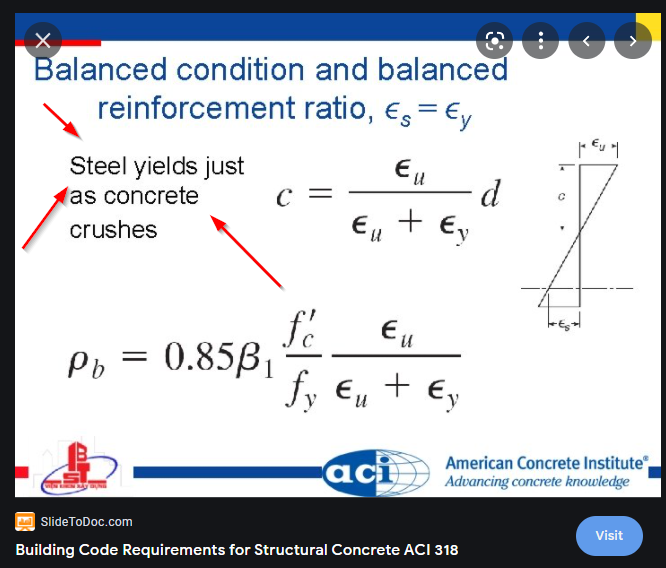

In [ ]:
f_cm = 48
beta_1 = get_beta_1(f_cm)
f_sy = 500
E_s = 200000
eps_sy = f_sy/E_s
eps_cu = EC2.get_eps_cu1(f_cm-8) # usually 0.003 according to ACI
rho_b = 0.85 * beta_1 * (f_cm/f_sy) * (eps_cu/(eps_cu + eps_sy))
rho_b

### Flexural strength according to ACI 318M-19

In [ ]:
A_s = 1200
d = 280
b = 200
a = A_s * f_sy/(0.85 * f_cm * b)
M_n = A_s * f_sy * (d - a/2) /1e6
M_n

### Effect of different concrete grade on $M_u$ according to ACI code 

In [ ]:
n_rho = 50

def get_M_u_steel(f_cm = 48, rho_list = np.linspace(0.0002, 0.025, n_rho)):
    n_rho = 50
    b = 200
    d = 280
    f_sy = 500
    a = (rho_list * b * d) * f_sy/(0.85 * f_cm * b)
    M_n = rho_list * b * d * f_sy * (d - a/2) /1e6
    return M_n

fig, ax = plt.subplots()
fig.set_size_inches(5.5, 3.4)

rho_list = np.linspace(0.0002, 0.025, n_rho)
for f_cm in [48, 108]:
    M_n = get_M_u_steel(f_cm=f_cm, rho_list=rho_list)
    M_max = M_n[-1]
    ax.axhline(y=M_max, color='r')
    ax.annotate(r'$M_{\mathrm{max, ' + str(rho_list[-1]) + '}} = ' + str(round(M_max, 2)) + '$ kNm',
                   xy=(0, 1.04 * M_max), color='r')
    ax.plot(rho_list, M_n)
fig.savefig('Default_setup_M_rho_ACI_steel.pdf')
fig

# SLS Study


$q_{GZT}$ = F_u in the code\
$q_{GZG}$ = F_s in the code\
$\gamma_{carbon}$ 1.3/(0.85*0.9)

## Carbon

In [ ]:
b_sls = BeamSLSCurve(n_i = 16, rein_type = 'carbon_grid', f_ck=40) #, rein_type = 'steel'
ps = SLSParamStudy(b_sls)
# b_sls.run()
# b_sls.apply_material_factors = False # I didn't apply them for carbon
# b_sls.use_f_ctm_fl = False
# b_sls.concrete_law = 'EC2 with plateau'

In [ ]:
b_sls.dp.interact()

In [ ]:
rho = 0.005
l_d = 8
270*1000*rho, l_d*270

In [ ]:
b_sls.dp.n_kappa= 200
b_sls.dp.n_m = 200
b_sls.dp.n_load_steps = 150

fig, ax = plt.subplots()
b_sls.dp.plot_fw_with_fmax(ax)
# fig.savefig('sls_carbon_rho_0.005_ld_7_fw.pdf')
fig

In [ ]:
fig.savefig('steel_carbon_sl_8_rho_0.5.pdf')

In [ ]:
b_sls.dp.plot_fw_with_fmax(ax)
fig

In [ ]:
fig = b_sls.dp.mc.plot_M_rho_and_stress_rho(n_rho = 30)
fig.savefig('sls_study_C40_M_max_rho.pdf')

In [ ]:
params_config = [
#     ['f_ctm', b_sls, [1* EC2.get_f_ctm_fl(b_sls.f_ck, 300), 2* EC2.get_f_ctm_fl(b_sls.f_ck, 300)]],
#     ['f_ctm', b_sls, [1* EC2.get_f_ctm(b_sls.f_ck), 2* EC2.get_f_ctm(b_sls.f_ck), 3* EC2.get_f_ctm(b_sls.f_ck)]],
#     [['f_ck', b_sls, [30, 50, 70]], ['f_ctm', b_sls, [7.5, 10.58, 12]]],
#     [['f_ck', b_sls, [30, 70]], ['f_ctm', b_sls, [0, 0]]],
#         [['f_ck', b_sls, [10]], ['f_ctm', b_sls, [4]]],
#     ['f_ck', b_sls, [40, 70, 100]],
#     ['sls_to_uls_ratio', b_sls, [0.51, 0.59, 0.68]]
    ['concrete_law', b_sls, ['EC2 with plateau', 'EC2']],
#     ['n_i', b_sls, [5, 11, 15]],
#     ['dense_quarter', b_sls, [True, False]],
#     ['use_f_ctm_fl', b_sls, [True, False]],
#     ['apply_material_factors', b_sls, [True, False]],
#     ['rein_type', b_sls, ['carbon_grid', 'carbon_rebars']],
#     ['H', b_sls.dp.mc.cross_section_shape_, [200, 400, 600]],
#     ['B', b_sls.dp.mc.cross_section_shape_, [1000, 500, 200]],
#     [['B', b_sls.dp.mc.cross_section_shape_, [1000, 200, 300]], ['H', b_sls.dp.mc.cross_section_shape_, [300, 400, 700]]],
]
fig = ps.run(params_config, savefig=True)
# fig.savefig('sls_carbon_grid_factors_off.pdf')

In [ ]:
fig.savefig('sls_carbon_grid_factors_off_concrete_law.pdf')

In [ ]:
# sls.plot_F_u()
sls.plot_F_u(bending_shear_diff = True)
# sls.plot_F_u(load='shear')

## Steel

In [ ]:
b_sls2 = BeamSLSCurve(n_i = 16, rein_type = 'steel', f_ck=40) #, rein_type = 'steel'
ps2 = SLSParamStudy(b_sls2)
b_sls2.run()

In [ ]:
b_sls2.interact()

In [ ]:
params_config = [
    ['f_ck', b_sls2, [40]],
]
fig = ps2.run(params_config, savefig=True)
# fig.savefig('sls_steel_grid_factors_off.pdf')

In [ ]:
fig, ax = plt.subplots()
b_sls2.dp.mc.plot_mk(ax)
fig.savefig('sls_steel_rho_0.005_ld_7_mc.pdf')
fig

In [ ]:
fig, ax = plt.subplots()
b_sls2.dp.plot_fw_with_fmax(ax)
fig.savefig('sls_steel_rho_0.005_ld_7_fw.pdf')
fig

## Tensile vs compression failure zones

In [ ]:
dp = b_sls.dp
mc = dp.mc
# for rho in b_sls.rho_range:
#     area_g = mc.cross_section_shape_.get_cs_area()
#     A_j_g = rho * area_g
#     mc.cross_section_layout.items[0].A = A_j_g
#     mc.M_t / mc.M_scale

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(b_sls.rho_grid, b_sls.sl_grid, b_sls.F_u_grid,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
fig

In [ ]:
np.linspace(0, 5000, 30)
fig, ax = plt.subplots()
# z = b_sls.F_u_grid / b_sls.F_s_grid - 1. / b_sls.sls_to_uls_ratio
z = b_sls.F_u_grid
cs = ax.contour(b_sls.rho_grid, b_sls.sl_grid, z, levels=[0, 10, 20, 50, 80, 100, 150, 300, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax.clabel(cs, inline=True, fontsize=10)
fig